**Step 1 : Clone yolov8 repository**

In [4]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
Setup complete ✅ (48 CPUs, 93.1 GB RAM, 408.6/467.8 GB disk)


In [5]:
from ultralytics import YOLO

from IPython.display import display, Image

In [3]:
# from google.colab import drive 
# drive.mount('/content/drive')

In [14]:
!mkdir yolov8
%cd yolov8

/workplace/OpticalRemoteSensingClassification/yolov8


In [15]:
!unzip  "/workplace/OpticalRemoteSensingClassification/ShipRSImageNet_V1_resized.zip" -d training_data

Archive:  /workplace/OpticalRemoteSensingClassification/ShipRSImageNet_V1_resized.zip
   creating: training_data/ShipRSImageNet_V1/
   creating: training_data/ShipRSImageNet_V1/COCO_Format/
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipImageNet_train_bnbox_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_1.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_2.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_test_level_3.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_0.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_1.json  
  inflating: training_data/ShipRSImageNet_V1/COCO_Format/ShipRSImageNet_bbox_train_level_2.json  
  inflating: training_data/Ship

In [16]:
import torch
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm
from random import choice
import shutil
import math
import tensorflow as tf
tf.random.set_seed(420)

In [17]:
def extract_from_xml(xml_file):
    # print(xml_file)
    root = ET.parse(xml_file).getroot()
    # Initialise the dict 
    dict = {}
    dict['bboxes'] = []
    dict['new_width'] = 512
    dict['new_height'] = 512
    # Parse the XML Tree
    for elem in root:
        if os.path.exists(xml_file):
          # Get the file name 
          if elem.tag == "filename":
              dict['filename'] = elem.text

          elif elem.tag == "size":
              image_size = []
              for subelem in elem:
                if subelem.tag == "width":
                  dict['old_width']=int(subelem.text)
                  image_size.append(dict['new_width'])
                elif subelem.tag == "height":
                  dict['old_height']=int(subelem.text)
                  image_size.append(dict['new_height'])
                elif subelem.tag == "depth":
                  image_size.append(int(subelem.text))
              dict['image_size'] = tuple(image_size)
          
          # Get details of the bounding box 
          elif elem.tag == "object":
              bbox = {}
              for subelem in elem:
                  if subelem.tag == "name":
                        bbox['class'] = subelem.text
                      
                  # elif subelem.tag == "rotated_box":
                  #     for subsubelem in subelem:
                  #         bbox[subsubelem.tag] = float(subsubelem.text) 
                  elif subelem.tag == "bndbox":
                      for subsubelem in subelem:
                        if subsubelem.tag == 'xmin' or subsubelem.tag == 'xmax':
                          bbox[subsubelem.tag] = (int(subsubelem.text) * dict['new_width'])/ dict['old_width']
                        elif subsubelem.tag == 'ymin' or subsubelem.tag == 'ymax':
                          bbox[subsubelem.tag] = (int(subsubelem.text) * dict['new_height'])/ dict['old_height']
              dict['bboxes'].append(bbox)
        else:
            break
    return dict
print(extract_from_xml('training_data/ShipRSImageNet_V1/VOC_Format/Annotations/000160.xml'))
# print(extract_from_xml('training_data/ShipRSImageNet_V1/VOC_Format/Annotations/*'))

{'bboxes': [{'class': 'Submarine', 'xmin': 133.78064516129032, 'ymin': 145.89247311827958, 'xmax': 338.5806451612903, 'ymax': 356.1978494623656}, {'class': 'Submarine', 'xmin': 175.6215053763441, 'ymin': 121.11827956989248, 'xmax': 384.8258064516129, 'ymax': 330.3225806451613}], 'new_width': 512, 'new_height': 512, 'filename': '000160.bmp', 'old_width': 930, 'old_height': 930, 'image_size': (512, 512, 3)}


In [18]:
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "xml"]
annotations.sort()
# extract from xml file
for ann in tqdm(annotations):
    dict = extract_from_xml(ann)
    # print(dict)

100%|██████████| 2748/2748 [00:00<00:00, 2901.53it/s]


In [19]:
class_id_mapping= {"Other Ship": 0, "Other Warship": 1, "Submarine": 2, "Other Aircraft Carrier": 3, "Enterprise": 4, "Nimitz": 5, "Midway": 6, "Ticonderoga": 7, "Other Destroyer": 8, "Atago DD": 9, "Arleigh Burke DD": 10, 
                  "Hatsuyuki DD": 11, "Hyuga DD": 12, "Asagiri DD": 13, "Other Frigate": 14, "Perry FF": 15, "Patrol": 16, "Other Landing": 17, "YuTing LL": 18, "YuDeng LL": 19, "YuDao LL": 20, "YuZhao LL": 21, "Austin LL": 22,
                  "Osumi LL": 23, "Wasp LL": 24, "LSD 41 LL": 25, "LHA LL": 26, "Commander": 27, "Other Auxiliary Ship": 28, "Medical Ship": 29, "Test Ship": 30, "Training Ship": 31, "AOE": 32, "Masyuu AS": 33, "Sanantonio AS": 34,
                  "EPF": 35, "Other Merchant": 36, "Container Ship": 37, "RoRo": 38, "Cargo": 39, "Barge": 40, "Tugboat": 41, "Ferry": 42, "Yacht": 43, "Sailboat": 44, "Fishing Vessel": 45,
                  "Oil Tanker": 46, "Hovercraft": 47, "Motorboat": 48, "Dock": 49}

                  
# Convert the info dict to the yolo format and write it to colab
def convert_to_yolov8(dict):
    print_buffer = []
    
    # For each bounding box
    for b in dict["bboxes"]:
        try:
            class_id = class_id_mapping[b["class"]]
        except KeyError:
            print(b["class"])
            print("Invalid Class")
        
        # Transform the bbox co-ordinates as per YOLOv8 format(for obb)
        # xc = b["cx"] * (dict['new_width'] / dict['old_width'])
        # yc = b["cy"] * (dict['new_height'] / dict['old_height'])
        # w  = b["width"] * (dict['new_width'] / dict['old_width'])
        # h  = b["height"] *(dict['new_height'] / dict['old_height'])
        # r =  b["rot"]
        
        # Transform the bbox co-ordinates as per YOLOv8 format
        xc = (b["xmin"] + b["xmax"]) / 2 
        yc = (b["ymin"] + b["ymax"]) / 2
        w  = (b["xmax"] - b["xmin"])
        h  = (b["ymax"] - b["ymin"])

        # Normalise the co-ordinates
        image_w, image_h, image_c = dict["image_size"]
        xc /= image_w 
        yc /= image_h 
        w  /= image_w 
        h  /= image_h 
        # r /= 2 * math.pi
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, xc, yc, w, h))
        
    # Name of the file which we have to save 
    save_name = os.path.join("training_data/ShipRSImageNet_V1/VOC_Format/Annotations", dict["filename"].replace("bmp", "txt"))
    # print(save_file_name)
    # Save the annotation to colab
    print("\n".join(print_buffer), file= open(save_name, "w"))

In [20]:
# Get the annotations
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "xml"]
annotations.sort()
# Convert and save the annotations
for ann in tqdm(annotations):
    dict = extract_from_xml(ann)
    # print(dict)
    convert_to_yolov8(dict)
    os.remove(ann)
annotations = [os.path.join('training_data/ShipRSImageNet_V1/VOC_Format/Annotations', x) for x in os.listdir('training_data/ShipRSImageNet_V1/VOC_Format/Annotations') if x[-3:] == "txt"]

100%|██████████| 2748/2748 [00:00<00:00, 2758.69it/s]


In [21]:
!mkdir dataset
path='./dataset/images/'
os.mkdir(path)
os.mkdir(path+'train')
os.mkdir(path+'val')
os.mkdir(path+'test')
path='./dataset/annotations/'
os.mkdir(path)
os.mkdir(path+'train')
os.mkdir(path+'val')
os.mkdir(path+'test')
old_name = r"./dataset/annotations/"
new_name = r"./dataset/labels/"
os.rename(old_name, new_name)

In [22]:
#path where annotations are stored 
path='./training_data/ShipRSImageNet_V1/VOC_Format/Annotations/'
count = len(os.listdir(path))
print(count)

array_imgs=[]
array_labels=[]
for (dirname, dirs, files) in os.walk(path):
    for filename in files:
        array_labels.append(filename)
        imgname=os.path.splitext(filename)[0]+'.bmp'
        array_imgs.append(imgname)

# 80% dataset is used for training and 20% for testing
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

#counting range for cycles
countTrain = int(len(array_imgs)*train_ratio)
countVal = int(len(array_labels)*val_ratio)
countTest = int(len(array_labels)*test_ratio)
print("training images are : ",countTrain)
print("Validation images are : ",countVal)
print("Test images are : ",countTest)

2748
training images are :  1923
Validation images are :  549
Test images are :  274


In [23]:
trainImgPath = './dataset/images/train'
trainlabelPath = './dataset/labels/train'
valImgPath = './dataset/images/val'
vallabelPath = './dataset/labels/val'
testImgPath = './dataset/images/test'
testlabelPath = './dataset/labels/test'
imgPath='./training_data/ShipRSImageNet_V1/VOC_Format/cloudless/'


#loop for train
for x in range(int(countTrain)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(trainImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(trainlabelPath, fileXml))

    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

#loop for val   
for x in range(int(countVal)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(valImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(vallabelPath, fileXml))
    
    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

#loop for test   
for x in range(int(countTest)):

    fileJpeg = choice(array_imgs) # name of random image from origin dir
    fileXml = fileJpeg[:-4] +'.txt' # name of corresponding annotation file

    shutil.copy(os.path.join(imgPath, fileJpeg), os.path.join(testImgPath, fileJpeg))
    shutil.copy(os.path.join(path, fileXml), os.path.join(testlabelPath, fileXml))
    
    array_imgs.remove(fileJpeg)
    array_labels.remove(fileXml)

In [24]:
# Create .yaml file 
import yaml

data_yaml = {
    'train' : f'/workplace/OpticalRemoteSensingClassification/yolov8/dataset/images/train',
    'val' : f'/workplace/OpticalRemoteSensingClassification/yolov8/dataset/images/val',
    'test' : f'/workplace/OpticalRemoteSensingClassification/yolov8/dataset/images/test',
    'nc' : 50,
    'names' : ['Other Ship', 'Other Warship', 'Submarine', 'Other Aircraft Carrier', 'Enterprise', 'Nimitz', 'Midway', 'Ticonderoga', 'Other Destroyer', 'Atago DD', 'Arleigh Burke DD', 
              'Hatsuyuki DD', 'Hyuga DD', 'Asagiri DD', 'Other Frigate', 'Perry FF', 'Patrol', 'Other Landing', 'YuTing LL', 'YuDeng LL', 'YuDao LL', 'YuZhao LL', 'Austin LL',
              'Osumi LL', 'Wasp LL', 'LSD 41 LL', 'LHA LL', 'Commander', 'Other Auxiliary Ship', 'Medical Ship', 'Test Ship', 'Training Ship', 'AOE', 'Masyuu AS', 'Sanantonio AS',
              'EPF', 'Other Merchant', 'Container Ship', 'RoRo', 'Cargo', 'Barge', 'Tugboat', 'Ferry', 'Yacht', 'Sailboat', 'Fishing Vessel',
              'Oil Tanker', 'Hovercraft', 'Motorboat', 'Dock']
}

    # Note that I am creating the file in the yolov8/data/ directory.
with open(f'/workplace/OpticalRemoteSensingClassification/yolov8/dataset/ship_custom.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

%cat /workplace/OpticalRemoteSensingClassification/yolov8/dataset/ship_custom.yaml

{names: [Other Ship, Other Warship, Submarine, Other Aircraft Carrier, Enterprise,
    Nimitz, Midway, Ticonderoga, Other Destroyer, Atago DD, Arleigh Burke DD, Hatsuyuki
      DD, Hyuga DD, Asagiri DD, Other Frigate, Perry FF, Patrol, Other Landing, YuTing
      LL, YuDeng LL, YuDao LL, YuZhao LL, Austin LL, Osumi LL, Wasp LL, LSD 41 LL,
    LHA LL, Commander, Other Auxiliary Ship, Medical Ship, Test Ship, Training Ship,
    AOE, Masyuu AS, Sanantonio AS, EPF, Other Merchant, Container Ship, RoRo, Cargo,
    Barge, Tugboat, Ferry, Yacht, Sailboat, Fishing Vessel, Oil Tanker, Hovercraft,
    Motorboat, Dock], nc: 50, test: /workplace/OpticalRemoteSensingClassification/yolov8/dataset/images/test,
  train: /workplace/OpticalRemoteSensingClassification/yolov8/dataset/images/train,
  val: /workplace/OpticalRemoteSensingClassification/yolov8/dataset/images/val}


In [25]:
!yolo task=detect mode=train model=yolov8x.pt data='/workplace/OpticalRemoteSensingClassification/yolov8/dataset/ship_custom.yaml' epochs=100 batch=10 imgsz=512 plots=True save=True project='yolov8_classify_cloudless' name='yolov8_results' cache

100%|████████████████████████████████████████| 131M/131M [00:07<00:00, 17.5MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8x.yaml, data=/workplace/OpticalRemoteSensingClassification/yolov8/dataset/ship_custom.yaml, epochs=100, patience=50, batch=10, imgsz=512, save=True, cache=True, device=, workers=8, project=yolov8_classify_cloudless, name=yolov8_results, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

**Validation**

In [33]:
!yolo task=detect mode=val data='/workplace/OpticalRemoteSensingClassification/yolov8/dataset/ship_custom.yaml' model='yolov8_classify_cloudless/yolov8_results/weights/best.pt' batch=10 imgsz=512 plots=True project='yolov8_classify_cloudless' name='Validation' augment conf=0.5

2023-05-18 16:31:33.902199: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 16:31:34.053113: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
Model summary (fused): 268 layers, 68171718 parameters, 0 gradients, 257.7 GFLOPs
val: Scanning /workplace/OpticalRemoteSensingClassification/yolov8/dataset/label
val: WARNING ⚠️ /workplace/OpticalRemoteSensingClassification/yolov8/dataset/images/val/2

**Run YOLO8 Inference on test images** 

In [34]:
!yolo task=detect mode=predict model='yolov8_classify_cloudless/yolov8_results/weights/best.pt' conf=0.5 source='dataset/images/test' save=True augment project='yolov8_classify_cloudless' name='classify_test' line_thickness=1

2023-05-18 16:32:32.344890: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 16:32:32.494297: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-2.0.1+cu117 CUDA:0 (Tesla V100-PCIE-32GB, 32501MiB)
Model summary (fused): 268 layers, 68171718 parameters, 0 gradients, 257.7 GFLOPs
image 1/274 /workplace/OpticalRemoteSensingClassification/yolov8/dataset/images/test/000027.bmp: 512x512 1 Dock, 111.8ms
image 2/274 /workplace/OpticalRemoteSensingClassi

In [35]:
!zip -r results_classify_cloudless.zip yolov8_classify_cloudless

  adding: yolov8_classify_cloudless/ (stored 0%)
  adding: yolov8_classify_cloudless/yolov8_results/ (stored 0%)
  adding: yolov8_classify_cloudless/yolov8_results/weights/ (stored 0%)
  adding: yolov8_classify_cloudless/yolov8_results/weights/last.pt (deflated 8%)
  adding: yolov8_classify_cloudless/yolov8_results/weights/best.pt (deflated 8%)
  adding: yolov8_classify_cloudless/yolov8_results/args.yaml (deflated 51%)
  adding: yolov8_classify_cloudless/yolov8_results/events.out.tfevents.1684421552.76f2ba8b81a9.30384.0 (deflated 72%)
  adding: yolov8_classify_cloudless/yolov8_results/train_batch0.jpg (deflated 13%)
  adding: yolov8_classify_cloudless/yolov8_results/train_batch1.jpg (deflated 13%)
  adding: yolov8_classify_cloudless/yolov8_results/train_batch2.jpg (deflated 18%)
  adding: yolov8_classify_cloudless/yolov8_results/results.csv (deflated 85%)
  adding: yolov8_classify_cloudless/yolov8_results/train_batch17370.jpg (deflated 22%)
  adding: yolov8_classify_cloudless/yolov8_re

In [21]:
# import shutil
# shutil.copy("results_classify_generated.zip","/content/drive/MyDrive/NITC_project/")

'/content/drive/MyDrive/NITC_project/results_classify_cloudless.zip'

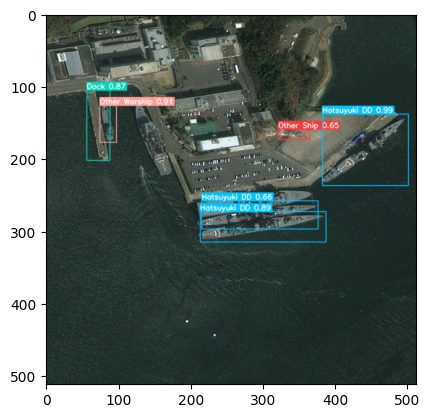

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = './yolov8_classify_cloudless/classify_test/000056.bmp'

# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

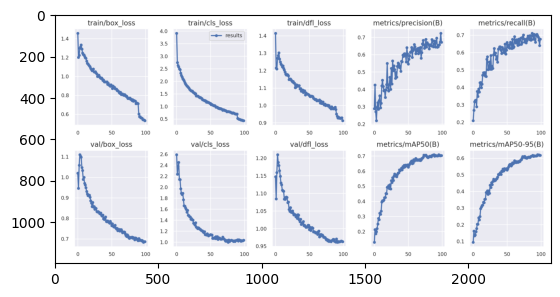

In [37]:
img_path='./yolov8_classify_cloudless/yolov8_results/results.png'
# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

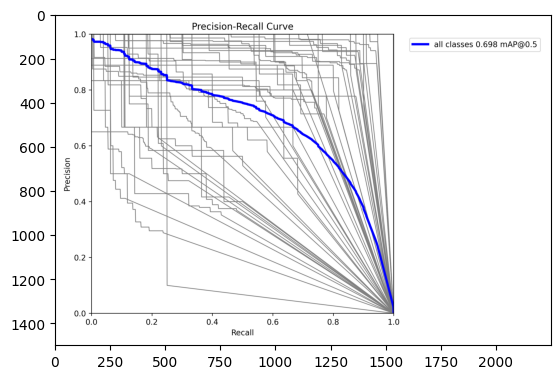

In [38]:
img_path='./yolov8_classify_cloudless/Validation/PR_curve.png'
# Load image
img = mpimg.imread(img_path)

# Display image
plt.imshow(img)
plt.show()

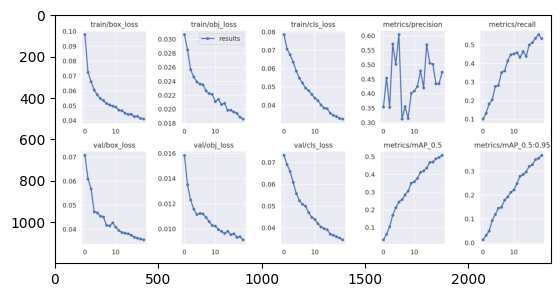

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# img_path = './yolov5_detect/yolov5_results2/results.png'
# # Load image
# img = mpimg.imread(img_path)

# # Display image
# plt.imshow(img)
# plt.show()

**Step 5: Display image in colab**

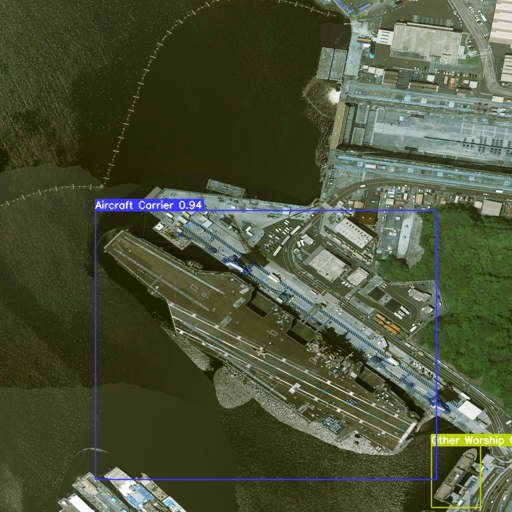

In [ ]:
# from google.colab.patches import cv2_imshow
# from skimage import io
# img_path='./runs/detect/infer_results/000003.bmp'
# image=io.imread(img_path)
# cv2_imshow(image)

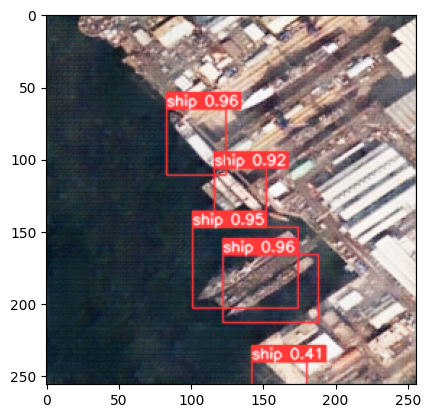

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg

# img_path = './runs/detect/infer_results/000037.bmp'

# # Load image
# img = mpimg.imread(img_path)

# # Display image
# plt.imshow(img)
# plt.show()